<div style="display: inline-block; text-align: center; float: left; margin-right: 25px;">
    <a href="https://www.linkedin.com/in/jason-wittenauer-28026110/"><img src="bin/Profile.png" align=left></a>
</div>

# Introduction to Survey Segmentation
11/17/2019

## In this tutorial you will learn the basics of verify segmentation, analyzing the data, and creating segments.

When reviewing survey data, you will typically be handed likert questions (ex: answers with a scale of 1 to 5 with 1 being bad and 5 being good). Using a few techniques, you can verify the quality of the survey and start grouping respondents into populations. The steps we will be following are listed below:

 - Analyzing our data set for scale.
 - Using Principle Component Analysis (PCA) to verify that the survey is sound and grouping data.
 - Checking for correlated questions.
 - Setting up the Exploratory Factor Analysis (EFA) to create the final segments.

### Data Review
The data set we will be using consists of 90 respondents answering questions based on how they like to shop for cars. This data was originally sourced from PromptCloud [here](https://www.promptcloud.com/wp-content/uploads/2017/02/EFA.csv), but can be found in this repository under the data folder. There are 14 options that respondents are considering when they buy a car: price, safety, exterior looks, etc. You will notice that there is a Respondent ID column added to the file placed in this repository. We will want to be able to tie the respondents to their segments for future reporting, so there should always be an ID included in your data set.

### Setup Library
First step is to setup all of the packages that will be used in this analysis. The two main packages for the analysis are PCA and Factor Analyzer to generate all of the modeling statistics we need to create our survey groupings.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
import os

### Import Data
Next we will read in our data set

In [2]:
os.chdir('C:\\Projects\\Survey Segmentation')
df = pd.read_csv('Data\\CarPurchaseSurvey.csv')

df.head(10)

,Respondent_ID,Price,Safety,Exterior_Looks,Space_Comfort,Technology,After_Sales_Service,Resale_Value,Fuel_Type,Fuel_Efficiency,Color,Maintenance,Test_drive,Product_Reviews,Testimonials
0,1,4,4,5,4,3,4,5,4,4,2,4,2,4,3
1,2,3,5,3,3,4,4,3,4,3,4,3,2,2,2
2,3,4,4,3,4,5,5,5,4,5,4,5,4,4,3
3,4,4,4,4,3,3,4,5,5,4,4,4,2,5,3
4,5,5,5,4,4,5,4,5,3,4,5,5,5,5,2
5,6,4,4,5,3,4,5,3,4,3,2,3,2,2,3
6,7,3,4,3,4,3,5,3,4,5,4,3,5,2,4
7,8,4,3,4,4,5,4,5,4,4,4,5,2,4,4
8,9,5,4,5,4,3,5,5,4,4,4,4,2,4,4
9,10,4,4,3,3,5,4,5,5,4,5,5,2,2,4


As you can see, the data set has already been converted to numbers. If this has not been done on your data set, you will need to convert any text like "Good", "Neutral", "Bad", etc. into a numeric format. In this data set, 1 is very low and 5 is very high.

### Confirm Answer Scale

In case you don't know much about the survey data that is being analyzed, you can always check the scale of all the columns by looking for the min, max, and unique value counts. This will let you know if you need to rescale the data or not.

In [3]:
columnStatistics = pd.DataFrame(df.max(axis=0)) # will return max value of each column
columnStatistics.columns = ['MaxValues']

columnStatistics['MinValues'] = df.min(axis=0) # will return min value of each column

uniqueCounts = pd.DataFrame(columnStatistics.index)
uniqueCounts.set_index(0, inplace=True)
uniqueCounts['UniqueValues'] = np.nan
for col in df:
    uniqueCounts.loc[col]['UniqueValues'] = df[col].nunique() # will return min value of each column
columnStatistics['UniqueValues'] = uniqueCounts['UniqueValues']

columnStatistics

,MaxValues,MinValues,UniqueValues
Respondent_ID,90,1,90.0
Price,5,3,3.0
Safety,5,3,3.0
Exterior_Looks,5,1,5.0
Space_Comfort,5,2,4.0
Technology,5,1,5.0
After_Sales_Service,5,2,4.0
Resale_Value,5,1,5.0
Fuel_Type,5,3,3.0
Fuel_Efficiency,5,1,5.0


It appears we have a scale of 1 to 5 for all of these questions. Be careful with assuming the scale though, you could end up with a question that just didn't have responses at the top or low end. This would make it appear to be on the same scale, when it actually is not. The best option is always to review the original survey to verify all question scales. For our purposes, these questions were all on the same scale.

### Prepare Data

When we analyze the data set in PCA and EFA, we do not want to include the ID column as part of the analysis. However, we do want to keep it around for reference purposes. Let's make it the dataframe index.

In [4]:
df.set_index('Respondent_ID', inplace=True)

### Check Survey Validity Using PCA

Now we can run PCA to determine if the survey was written well enough to put respondents into various segments. First we will setup our covariance matrix.

In [5]:
covar_matrix = PCA(n_components = len(df.columns)) #components are equal to the number of features we have
covar_matrix.fit(df)

PCA(copy=True, iterated_power='auto', n_components=14, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Next we will plot the eigenvalues of our features to verify that there are at a minimum 2-3 features that have a value greater than 1.

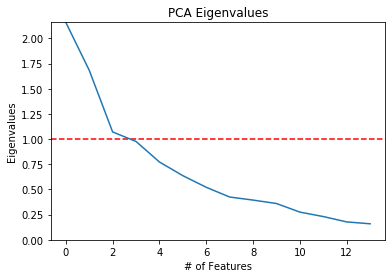

In [6]:
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.title('PCA Eigenvalues')
plt.ylim(0,max(covar_matrix.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=1, color='r', linestyle='--')
plt.plot(covar_matrix.explained_variance_)
plt.show()

After confirming the eigenvalues, we can check to see that something less than the total number of features are explaining a large portion of the variance. In this case, we set the threshold at 80% and it looks like 6 features (less than 14) are explaining at least 80% of the variance.

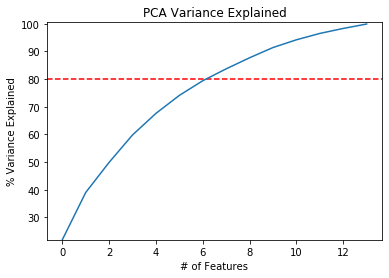

In [7]:
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Variance Explained')
plt.ylim(min(var),100.5)
plt.style.context('seaborn-whitegrid')
plt.axhline(y=80, color='r', linestyle='--')
plt.plot(var)
plt.show()

The last part of our initial survey validation checks is to make sure that the components of the PCA are showing different types of populations. If all the populations show Safety and Resale_Value as their top 2 features, then the survey isn't segmenting the population very well. In our below code, we will be looking at the top 3 features for each component, which look like very different populations.

In [8]:
components = pd.DataFrame(covar_matrix.components_ ,columns = df.columns)
components.rename(index = lambda x: 'PC-' + str(x + 1), inplace=True)

# Top 3 positive contributors
pd.DataFrame(components.columns.values[np.argsort(-components.values, axis=1)[:, :3]], 
                  index=components.index,
                  columns = ['1st Max','2nd Max','3rd Max'])

,1st Max,2nd Max,3rd Max
PC-1,Safety,Exterior_Looks,Testimonials
PC-2,Resale_Value,Price,Maintenance
PC-3,Exterior_Looks,Test_drive,Resale_Value
PC-4,Technology,Space_Comfort,Fuel_Type
PC-5,Test_drive,After_Sales_Service,Safety
PC-6,Fuel_Efficiency,Safety,Fuel_Type
PC-7,Product_Reviews,Maintenance,Test_drive
PC-8,Exterior_Looks,Fuel_Efficiency,Color
PC-9,Fuel_Efficiency,Technology,Product_Reviews
PC-10,Fuel_Type,Maintenance,Space_Comfort


### Correlating Questions

Survey questions can sometimes not produce different results. For example, everyone who rates Safety high might also rate Technology high. When that happens, having both questions doesn't necessarily help with doing a mathematical segmentation. This doesn't mean that they are invalid questions to have listed though. There could be a lot of business value to knowing that Safety and Technology correlate highly. When you find correlating questions, it is a good idea to discuss with your business users which ones should be removed (if any!).

Our raw data output of correlating questions can be seen below (1 = perfect correlation and 0 = no correlation).

In [9]:
df.corr() #data output

,Price,Safety,Exterior_Looks,Space_Comfort,Technology,After_Sales_Service,Resale_Value,Fuel_Type,Fuel_Efficiency,Color,Maintenance,Test_drive,Product_Reviews,Testimonials
Price,1.000000,-0.090037,0.015695,0.117495,0.014658,0.054002,0.376110,0.138378,0.279584,0.083301,0.302642,-0.025885,0.280548,-0.113739
Safety,-0.090037,1.000000,-0.081891,0.241991,0.024152,0.204918,-0.190679,0.146573,-0.140759,-0.061001,-0.200373,0.003159,-0.067165,-0.076574
Exterior_Looks,0.015695,-0.081891,1.000000,0.168733,0.070869,0.033371,-0.058420,0.051573,-0.136067,-0.332963,-0.110342,0.160258,0.048554,0.111352
Space_Comfort,0.117495,0.241991,0.168733,1.000000,0.275772,0.316670,-0.212070,0.478180,0.125239,-0.130601,0.066855,0.185522,0.232008,0.157778
Technology,0.014658,0.024152,0.070869,0.275772,1.000000,0.281370,-0.068670,0.213874,0.029165,0.066103,0.186086,0.057090,0.103233,0.054786
After_Sales_Service,0.054002,0.204918,0.033371,0.316670,0.281370,1.000000,0.083962,0.258700,0.417234,0.091052,0.143271,0.216529,0.098232,0.010328
Resale_Value,0.376110,-0.190679,-0.058420,-0.212070,-0.068670,0.083962,1.000000,-0.048843,0.326702,0.122955,0.439128,0.021318,0.112873,-0.228278
Fuel_Type,0.138378,0.146573,0.051573,0.478180,0.213874,0.258700,-0.048843,1.000000,0.148904,-0.035157,0.024496,0.023931,0.057251,0.019467
Fuel_Efficiency,0.279584,-0.140759,-0.136067,0.125239,0.029165,0.417234,0.326702,0.148904,1.000000,0.352207,0.298139,0.284496,0.346580,0.070917
Color,0.083301,-0.061001,-0.332963,-0.130601,0.066103,0.091052,0.122955,-0.035157,0.352207,1.000000,0.374978,0.081111,0.194644,0.154741


This can also be visually represented in a heat map. In this visualization, darker is good because the questions do not correlate.

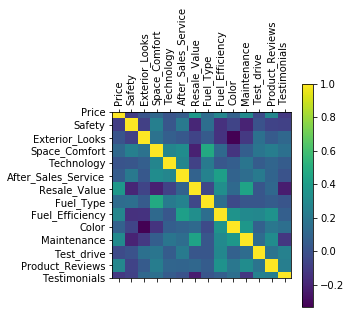

In [10]:
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

### Using EFA to Create Segments

Now that we have verified there is segmentation happening with the survey results, we can start analyzing how many segments we want. This is where is starts to mix between art and science. Sometimes you want more segments because it is important to include a feature that might not be captured with fewer segments. Other times, the business need might just be "create 4, and only 4 segments because we have 4 flavors of this new food being marketed". Regardless of the situation, we can use EFA to create our segments and verify that the segments are what we want.

### Review the Scree Plot
To start the analysis, we need to create a scree plot. To do this, we need to look at the eigenvalues.

In [11]:
fa = FactorAnalyzer(rotation=None, n_factors=len(df.columns))
fa.fit(df)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([2.75506068, 2.1640701 , 1.46454689, 1.32990296, 1.04029066,
       0.99198697, 0.80634535, 0.68102944, 0.60136568, 0.5536899 ,
       0.51364695, 0.46653069, 0.35660717, 0.27492656])

Now that we have a list of the eigenvalues, we can map them to our factors.

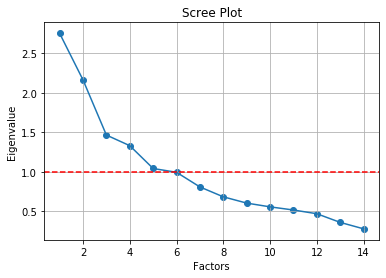

In [12]:
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

This plot should look very familiar, we used a similar plot above with the PCA. And just like that previous analysis, we are going to look for the number of factors that are above one to determine how many initial segments we would like to create. In this case, we will be creating 5 segments.

### Create Segments and Review Loadings

Now that we know there are 5 segments for the initial analysis, we can create a new model with those segments and see how each feature is positively or negatively reflected in each segment.

In [13]:
fa = FactorAnalyzer(rotation="varimax", n_factors=5)
fa.fit(df)

# Check loadings
loadings = pd.DataFrame(fa.loadings_)
loadings.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
loadings.index = df.columns
loadings

,Factor-1,Factor-2,Factor-3,Factor-4,Factor-5
Price,0.573617,0.146030,-0.045880,-0.040950,-0.019967
Safety,-0.276880,0.304749,-0.161114,0.112029,0.047257
Exterior_Looks,-0.007815,0.053317,0.197785,0.005544,-0.537709
Space_Comfort,0.023073,0.869068,0.206912,0.004440,-0.170585
Technology,0.041581,0.318130,0.085799,0.125403,0.027299
After_Sales_Service,0.056866,0.372065,0.056598,0.877193,0.036841
Resale_Value,0.693702,-0.221781,-0.172206,0.164311,0.010156
Fuel_Type,0.060285,0.537086,-0.017494,0.084929,-0.036865
Fuel_Efficiency,0.464085,0.092215,0.277061,0.368666,0.226392
Color,0.209059,-0.053291,0.256304,0.069493,0.744462


In the above table, each factor can be considered a segment. You might want to combine these for business purposes into super segments, but they do represent distinct populations. When we analyze the segments, it helps to put a limitation on the numbers/relationship strength. For example, if we remove everything that is less than .4 (positively or negatively), we end up with the below table.

In [14]:
segments = loadings[loadings >= .4].fillna(loadings[loadings <= -.4])
segments

,Factor-1,Factor-2,Factor-3,Factor-4,Factor-5
Price,0.573617,NaN,NaN,NaN,NaN
Safety,NaN,NaN,NaN,NaN,NaN
Exterior_Looks,NaN,NaN,NaN,NaN,-0.537709
Space_Comfort,NaN,0.869068,NaN,NaN,NaN
Technology,NaN,NaN,NaN,NaN,NaN
After_Sales_Service,NaN,NaN,NaN,0.877193,NaN
Resale_Value,0.693702,NaN,NaN,NaN,NaN
Fuel_Type,NaN,0.537086,NaN,NaN,NaN
Fuel_Efficiency,0.464085,NaN,NaN,NaN,NaN
Color,NaN,NaN,NaN,NaN,0.744462


Now we can start naming the segments based on the features that are within each factor. To do this, we just name the columns.

In [15]:
segment_names = ['Overall Cost', 'Comfort and Fuel Efficiency', 'Review Confirmer', 'Service', 'Color Trumps All']
segments.columns = segment_names
segments

,Overall Cost,Comfort and Fuel Efficiency,Review Confirmer,Service,Color Trumps All
Price,0.573617,NaN,NaN,NaN,NaN
Safety,NaN,NaN,NaN,NaN,NaN
Exterior_Looks,NaN,NaN,NaN,NaN,-0.537709
Space_Comfort,NaN,0.869068,NaN,NaN,NaN
Technology,NaN,NaN,NaN,NaN,NaN
After_Sales_Service,NaN,NaN,NaN,0.877193,NaN
Resale_Value,0.693702,NaN,NaN,NaN,NaN
Fuel_Type,NaN,0.537086,NaN,NaN,NaN
Fuel_Efficiency,0.464085,NaN,NaN,NaN,NaN
Color,NaN,NaN,NaN,NaN,0.744462


### Check Variance and Do Adequacy Checks

In [16]:
# Check variance
factorVariance = pd.DataFrame(fa.get_factor_variance())
factorVariance.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
factorVariance.index = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
factorVariance

,Factor-1,Factor-2,Factor-3,Factor-4,Factor-5
SS Loadings,1.716492,1.503685,1.085603,1.035058,1.002343
Proportion Variance,0.122607,0.107406,0.077543,0.073933,0.071596
Cumulative Variance,0.122607,0.230013,0.307556,0.381488,0.453084


It looks like 5 factors can explain 45% of our variance. We are probably wanting to shoot for something over 50%, so we need to increase the factor count. However, what really matters is the business case involved.

### Decision Time

We have validated our survey and come up with some initial segments. There is a catch though, our segments didn't use all of the survey questions (Safety and Technology were not used). If it is really important to find people to sell Safety or Technology features too, then we would need to increase the segments from 5 to 6 and re-run the EFA portion of our analysis. Another requirement might be we can only have 3 segments, so we need to either reduce the factors for the EFA (which would reduce the features used) or combine the 5 segments into 3 segments. Just knowing how to do a mathematically correct segmentation does not necessarily translate into something usable by a business. 

### Export for Reporting
Once the segments are approved, it is time to prepare the data for exporting. We will apply our segments to the original data, unpivot the correlation matrix, and unpivot the loadings for the report that can be found here: [Dashboard](https://public.tableau.com/profile/jason.wittenauer#!/vizhome/SurveySegmentation/Overview)

In [19]:
# Data mapped to factors
factor_scores = pd.DataFrame(fa.transform(df))
factor_scores.columns = segment_names
factor_scores['Respondent_ID'] = df.index
df_export = pd.merge(df, factor_scores, on='Respondent_ID')
df_export['Primary Segment'] = df_export[segment_names].idxmax(axis=1)
df_export.to_csv('Data\\Data_Scored.csv', index=False)

# Correlation matrix
correlation_export = df.corr().unstack().reset_index(name='value')
correlation_export.columns = ['Feature 1', 'Feature 2', 'Value']
correlation_export.to_csv('Data\\Correlations.csv', index=False)

# Loadings
loadings.columns = segment_names
loadings_export = loadings.unstack().reset_index(name='value')
loadings_export.columns = ['Segment', 'Feature', 'Value']
loadings_export.to_csv('Data\\Loadings.csv', index=False)

### Conclusion

In this tutorial, you learned how to create a segmentation analysis based on likert survey questions. Hopefully you feel empowered to generate your own analysis based on new data.